In [ ]:
!nvidia-smi

In [ ]:
!wget http://webeye.ophth.uiowa.edu/abramoff/AV_groundTruth.zip
!unzip AV_groundTruth.zip 

In [ ]:
import os
train_images_path = 'AV_groundTruth/training/images'
train_mask_path = 'AV_groundTruth/training/vessel'

test_images_path = 'AV_groundTruth/test/images'
test_mask_path = 'AV_groundTruth/test/vessel'

train_images_files = sorted([os.path.join(train_images_path, i) for i in os.listdir(train_images_path)])
train_mask_files = sorted([os.path.join(train_mask_path, i) for i in os.listdir(train_mask_path)])

test_images_files = sorted([os.path.join(test_images_path, i) for i in os.listdir(test_images_path)])
test_mask_files = sorted([os.path.join(test_mask_path, i) for i in os.listdir(test_mask_path)])

In [ ]:
print(len(train_images_files))
print(len(train_mask_files))
print(len(test_images_files))
print(len(test_mask_files))

20
20
20
20


In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout, average
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from albumentations import (Compose, OneOf, 
                            CLAHE, Flip, Rotate, RGBShift, RandomContrast, RandomGamma, RandomBrightness, 
                            Transpose, ShiftScaleRotate, RandomRotate90, OpticalDistortion, GridDistortion, ElasticTransform, 
                            IAAPiecewiseAffine, ChannelShuffle, RandomBrightnessContrast, RandomGamma, RandomCrop)

from sklearn.metrics import classification_report
from PIL import Image

# Generator 

In [ ]:
def read_image(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.resize(dim)
    img = np.array(img)
    return img

def read_mask(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.resize(dim)
    img = np.array(img)
    img = (img>0).astype(np.uint8)
    return img

#...............................................................................................................

class Train_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(512,512), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0), 
            
      OneOf([
             Flip(), 
             Transpose()
             ], p=1.0),
      OneOf([
             ShiftScaleRotate(),
             RandomRotate90()
             ], p=0.9),
      OneOf([
             OpticalDistortion(),
             GridDistortion(),
             ElasticTransform(),
     
      ], p=0.4),
      
      OneOf([
             RGBShift(),
             RandomBrightnessContrast(),
             RandomGamma()
             ], p=0.2)
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  
  
#...............................................................................................................

class Val_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(512,512), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0)
    ])


  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])
      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  

# Input pipeline 

In [ ]:
batch_img_dim = (10, 256, 256, 3)
batch_msk_dim = (10, 256, 256, 1)

def train_generator():
  return Train_Generator(train_images_files, train_mask_files, batch_size = batch_img_dim[0], img_dim=(batch_img_dim[1], batch_img_dim[2]), augmentation=True).__iter__()
def valid_generator():
  return Val_Generator(test_images_files, test_mask_files, batch_size = batch_img_dim[0], img_dim=(batch_img_dim[1], batch_img_dim[2]), augmentation=True).__iter__()

ds_train = tf.data.Dataset.from_generator(
    train_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([batch_img_dim[0], batch_img_dim[1], batch_img_dim[2], batch_img_dim[3]], [batch_msk_dim[0], batch_msk_dim[1], batch_msk_dim[2], batch_msk_dim[3]])
).repeat()

ds_valid = tf.data.Dataset.from_generator(
    valid_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([batch_img_dim[0], batch_img_dim[1], batch_img_dim[2], batch_img_dim[3]], [batch_msk_dim[0], batch_msk_dim[1], batch_msk_dim[2], batch_msk_dim[3]])
).repeat()


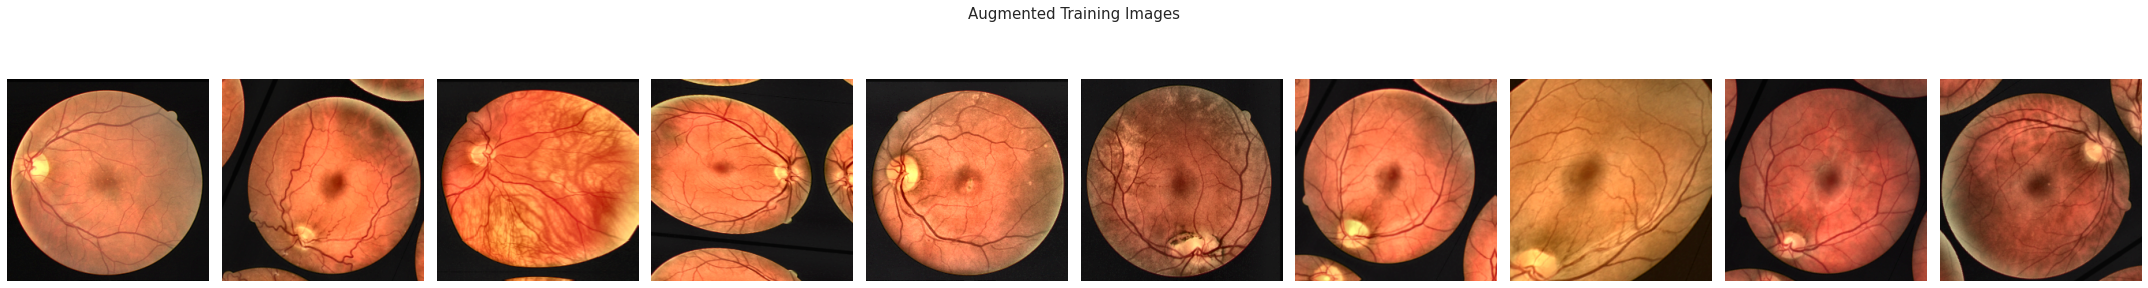

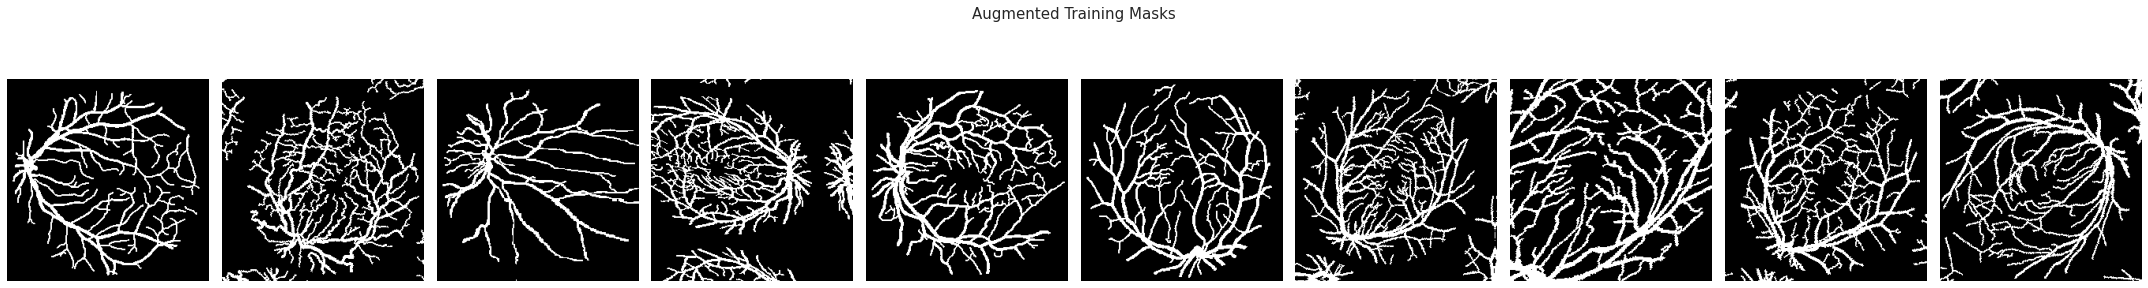

In [ ]:
for i, j in ds_train:
    break

fig, axes = plt.subplots(1, 10, figsize=(30,5))
fig.suptitle('Augmented Training Images', fontsize=)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(30,5))
fig.suptitle('Augmented Training Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

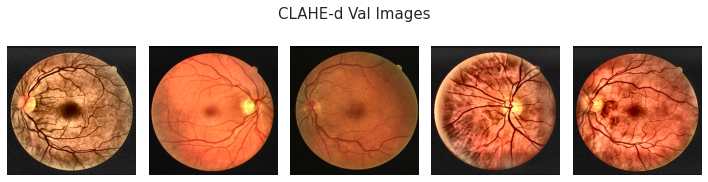

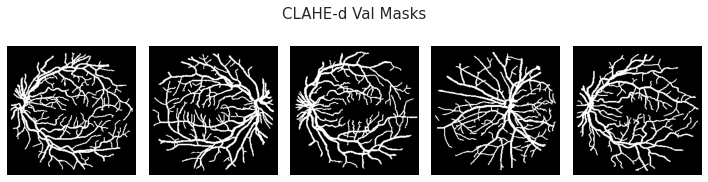

In [ ]:
for i, j in ds_valid:
    break

fig, axes = plt.subplots(1, 5, figsize=(10,3))
fig.suptitle('CLAHE-d Val Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(10,3))
fig.suptitle('CLAHE-d Val Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model 

In [ ]:
from tensorflow.keras.layers import Lambda 
class conv_bnorm(tf.keras.layers.Layer):

  def __init__(self, f, **kwargs):
    super(conv_bnorm, self).__init__(**kwargs)
    self.conv_1 = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.norm_1 = BatchNormalization()
    self.conv_2 = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.norm_2 = BatchNormalization()

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.norm_1(x)
    x = self.conv_2(x)
    x = self.norm_2(x)
    return x


def SubpixelUpsampling(x, y):
    depth = tf.keras.backend.int_shape(x)[-1]
    def depth_to_space(x):
          return tf.nn.depth_to_space(x, 2)
    x = Conv2D(filters=depth*2, kernel_size=(1,1), strides=1, padding='same', )(x)
    x = Lambda(depth_to_space)(x)
    x = concatenate([x, y])
    return x



inputs = Input((256,256,3), name='Input')

m1c1 = conv_bnorm(32, name='M1_conv_bnorm_d1') (inputs)
m1p1 = MaxPooling2D(name='M1_pool1') (m1c1)

m1c2 = conv_bnorm(64, name='M1_conv_bnorm_d2') (m1p1)
m1p2 = MaxPooling2D(name='M1_pool2') (m1c2)

m1c3 = conv_bnorm(128, name='M1_conv_bnorm_d3') (m1p2)
m1p3 = MaxPooling2D(name='M1_pool3') (m1c3)

m1c4 = conv_bnorm(256, name='M1_conv_bnorm_d4') (m1p3)
m1p4 = MaxPooling2D(name='M1_pool4') (m1c4)

m1c5 = conv_bnorm(512, name='M1_conv_bnorm_d5') (m1p4)
m1p5 = MaxPooling2D(name='M1_pool5') (m1c5)

m1c6 = conv_bnorm(1024, name='M1_conv_bnorm_d6') (m1p5) # Bottleneck

m1u5 = SubpixelUpsampling(m1c6, m1c5)
m1u5 = conv_bnorm(512, name='M1_conv_bnorm5_u5') (m1u5)

m1u4 = SubpixelUpsampling(m1u5, m1c4)
m1u4 = conv_bnorm(256, name='M1_conv_bnorm_u4') (m1u4)

m1u3 = SubpixelUpsampling(m1u4, m1c3)
m1u3 = conv_bnorm(128, name='M1_conv_bnorm_u3') (m1u3)

m1u2 = SubpixelUpsampling(m1u3, m1c2)
m1u2 = conv_bnorm(64, name='M1_conv_bnorm_u2') (m1u2)

m1u1 = SubpixelUpsampling(m1u2, m1c1)
m1u1 = conv_bnorm(32, name='M1_conv_bnorm_u1') (m1u1)

m1out = Conv2D(1, (1, 1), name='M1_output', activation='sigmoid') (m1u1) # Output


#-----------------------------------------------------------------------------


m2inp = concatenate([m1u1, inputs])

m2c1 = conv_bnorm(32, name='M2_conv_bnorm_d1') (m2inp)
m2p1 = MaxPooling2D(name='M2_pool1') (m2c1)

m2c2 = conv_bnorm(64, name='M2_conv_bnorm_d2') (m2p1)
m2p2 = MaxPooling2D(name='M2_pool2') (m2c2)

m2c3 = conv_bnorm(128, name='M2_conv_bnorm_d3') (m2p2)
m2p3 = MaxPooling2D(name='M2_pool3') (m2c3)

m2c4 = conv_bnorm(256, name='M2_conv_bnorm_d4') (m2p3)
m2p4 = MaxPooling2D(name='M2_pool4') (m2c4)

m2c5 = conv_bnorm(512, name='M2_conv_bnorm_d5') (m2p4) 
m2p5 = MaxPooling2D(name='M2_pool5') (m2c5)

m2c6 = conv_bnorm(1024, name='M2_conv_bnorm_d6') (m2p5)

m2u5 = SubpixelUpsampling(m2c6, m2c5)
m2u5 = concatenate([m2u5, m1u5])
m2u5 = conv_bnorm(512, name='M2_conv_bnorm_u5') (m2u5)

m2u4 = SubpixelUpsampling(m2c5, m2c4)
m2u4 = concatenate([m2u4, m1u4])
m2u4 = conv_bnorm(256, name='M2_conv_bnorm_u4') (m2u4)

m2u3 = SubpixelUpsampling(m2u4, m2c3)
m2u3 = concatenate([m2u3, m1u3])
m2u3 = conv_bnorm(128, name='M2_conv_bnorm_u3') (m2u3)

m2u2 = SubpixelUpsampling(m2u3, m2c2)
m2u2 = concatenate([m2u2, m1u2])
m2u2 = conv_bnorm(64, name='M2_conv_bnorm_u2') (m2u2)

m2u1 = SubpixelUpsampling(m2u2, m2c1)
m2u1 = concatenate([m2u1, m1u1])
m2u1 = conv_bnorm(32, name='M2_conv_bnorm_u1') (m2u1)

m2out = Conv2D(1, (1, 1), name='M2_output', activation='sigmoid') (m2u1)


#-----------------------------------------------------------------------------


m3inp = concatenate([m2u1, inputs])

m3c1 = conv_bnorm(32, name='M3_conv_bnorm_d1') (m3inp)
m3p1 = MaxPooling2D(name='M3_pool1') (m3c1)

m3c2 = conv_bnorm(64, name='M3_conv_bnorm_d2') (m3p1)
m3p2 = MaxPooling2D(name='M3_pool2') (m3c2)

m3c3 = conv_bnorm(128, name='M3_conv_bnorm_d3') (m3p2)
m3p3 = MaxPooling2D(name='M3_pool3') (m3c3)

m3c4 = conv_bnorm(256, name='M3_conv_bnorm_d4') (m3p3) 
m3p4 = MaxPooling2D(name='M3_pool4') (m3c4)

m3c5 = conv_bnorm(512, name='M3_conv_bnorm_d5') (m3p4)
m3p5 = MaxPooling2D(name='M3_pool5') (m3c5)

m3c6 = conv_bnorm(1024, name='M3_conv_bnorm_d6') (m3p5)

m3u5 = SubpixelUpsampling(m3c6, m3c5)
m3u5 = concatenate([m3u5, m1u5])
m3u5 = concatenate([m3u5, m2u5])
m3u5 = conv_bnorm(512, name='M3_conv_bnorm_u5') (m3u5)

m3u4 = SubpixelUpsampling(m3c5, m3c4)
m3u4 = concatenate([m3u4, m1u4])
m3u4 = concatenate([m3u4, m2u4])
m3u4 = conv_bnorm(256, name='M3_conv_bnorm_u4') (m3u4)

m3u3 = SubpixelUpsampling(m3u4, m3c3)
m3u3 = concatenate([m3u3, m1u3])
m3u3 = concatenate([m3u3, m2u3])
m3u3 = conv_bnorm(128, name='M3_conv_bnorm_u3') (m3u3)

m3u2 = SubpixelUpsampling(m3u3, m3c2)
m3u2 = concatenate([m3u2, m1u2])
m3u2 = concatenate([m3u2, m2u2])
m3u2 = conv_bnorm(64, name='M3_conv_bnorm_u2') (m3u2)

m3u1 = SubpixelUpsampling(m3u2, m3c1)
m3u1 = concatenate([m3u1, m1u1])
m3u1 = concatenate([m3u1, m2u1])
m3u1 = conv_bnorm(32, name='M3_conv_bnorm_u1') (m3u1)

m3out = Conv2D(1, (1, 1), name='M3_output', activation='sigmoid') (m3u1)

#-----------------------------------------------------------------------------


m4inp = concatenate([m3u1, inputs])

m4c1 = conv_bnorm(32, name='M4_conv_bnorm_d1') (m4inp)
m4p1 = MaxPooling2D(name='M4_pool1') (m4c1)

m4c2 = conv_bnorm(64, name='M4_conv_bnorm_d2') (m4p1)
m4p2 = MaxPooling2D(name='M4_pool2') (m4c2)

m4c3 = conv_bnorm(128, name='M4_conv_bnorm_d3') (m4p2)
m4p3 = MaxPooling2D(name='M4_pool3') (m4c3)

m4c4 = conv_bnorm(256, name='M4_conv_bnorm_d4') (m4p3)
m4p4 = MaxPooling2D(name='M4_pool4') (m4c4)

m4c5 = conv_bnorm(512, name='M4_conv_bnorm_d5') (m4p4)
m4p5 = MaxPooling2D(name='M4_pool5') (m4c5)

m4c6 = conv_bnorm(1024, name='M4_conv_bnorm_d6') (m4p5)

m4u5 = SubpixelUpsampling(m4c6, m4c5)
m4u5 = concatenate([m4u5, m1u5])
m4u5 = concatenate([m4u5, m2u5])
m4u5 = concatenate([m4u5, m3u5])
m4u5 = conv_bnorm(512, name='M4_conv_bnorm_u5') (m4u5)

m4u4 = SubpixelUpsampling(m4c5, m4c4)
m4u4 = concatenate([m4u4, m1u4])
m4u4 = concatenate([m4u4, m2u4])
m4u4 = concatenate([m4u4, m3u4])
m4u4 = conv_bnorm(256, name='M4_conv_bnorm_u4') (m4u4)

m4u3 = SubpixelUpsampling(m4u4, m4c3)
m4u3 = concatenate([m4u3, m1u3])
m4u3 = concatenate([m4u3, m2u3])
m4u3 = concatenate([m4u3, m3u3])
m4u3 = conv_bnorm(128, name='M4_conv_bnorm_u3') (m4u3)

m4u2 = SubpixelUpsampling(m4u3, m4c2)
m4u2 = concatenate([m4u2, m1u2])
m4u2 = concatenate([m4u2, m2u2])
m4u2 = concatenate([m4u2, m3u2])
m4u2 = conv_bnorm(64, name='M4_conv_bnorm_u2') (m4u2)

m4u1 = SubpixelUpsampling(m4u2, m4c1)
m4u1 = concatenate([m4u1, m1u1])
m4u1 = concatenate([m4u1, m2u1])
m4u1 = concatenate([m4u1, m3u1])
m4u1 = conv_bnorm(32, name='M4_conv_bnorm_u1') (m4u1)

m4out = Conv2D(1, (1, 1), name='M4_output', activation='sigmoid') (m4u1)

K.clear_session()
model = Model(inputs=[inputs], outputs=[m1out, m2out, m3out, m4out])


# Loss, Metric & Compile

In [ ]:
def dice_loss(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred) + 1.0
  dice_score = (2. * intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.0)
  dice_loss = 1. - dice_score
  return dice_loss

def dice(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred) + 1.0
  dice_score = (2. * intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.0)
  return dice_score

def bce_dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def iou(y_true, y_pred):
  y_true = tf.cast(y_true>0.5, tf.float32)
  y_pred = tf.cast(y_pred>0.5, tf.float32)
  intersection = tf.reduce_sum(y_true * y_pred) + 1.0
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.0
  iou = intersection/union
  return iou


In [ ]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam

model.compile(optimizer =Adam(), loss=[dice_loss, dice_loss, dice_loss, dice_loss], metrics={'M1_output':[iou, dice],'M2_output':[iou, dice], 'M3_output':[iou, dice], 'M4_output':[iou, dice]}) 
# model.compile(optimizer =Adam(), loss=[dice_loss], metrics=[iou, dice])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopping = EarlyStopping(
  monitor='val_loss', 
  min_delta=0, 
  patience=10, 
  verbose=1, 
  restore_best_weights=True)

reducelr = ReduceLROnPlateau(
  monitor='val_loss', 
  factor=0.1, 
  patience=3, 
  verbose=1,  
  min_delta=0.0001 )

callbacks = [earlystopping, reducelr]

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model_UNET++.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=50
)

In [ ]:
model.summary()

# Fit 

In [ ]:
history = model.fit(
    ds_train, 
    steps_per_epoch = 40,
    epochs=100,
    validation_data = ds_valid,    
    validation_steps = 4,
    callbacks = callbacks
    )

Epoch 1/100
40/40 [==============================] - 44s 1s/step - loss: 1.9866 - M1_output_loss: 0.5611 - M2_output_loss: 0.5086 - M3_output_loss: 0.4673 - M4_output_loss: 0.4496 - M1_output_iou: 0.3051 - M2_output_iou: 0.3648 - M3_output_iou: 0.3977 - M4_output_iou: 0.4141 - val_loss: 2.7386 - val_M1_output_loss: 0.6713 - val_M2_output_loss: 0.6734 - val_M3_output_loss: 0.7051 - val_M4_output_loss: 0.6888 - val_M1_output_iou: 0.1985 - val_M2_output_iou: 0.1971 - val_M3_output_iou: 0.1729 - val_M4_output_iou: 0.1843
Epoch 2/100
40/40 [==============================] - 40s 1s/step - loss: 1.2896 - M1_output_loss: 0.3878 - M2_output_loss: 0.3302 - M3_output_loss: 0.2912 - M4_output_loss: 0.2803 - M1_output_iou: 0.5045 - M2_output_iou: 0.5581 - M3_output_iou: 0.5832 - M4_output_iou: 0.5917 - val_loss: 3.3803 - val_M1_output_loss: 0.6704 - val_M2_output_loss: 0.9869 - val_M3_output_loss: 0.8343 - val_M4_output_loss: 0.8886 - val_M1_output_iou: 0.1990 - val_M2_output_iou: 3.6950e-04 - val_

In [ ]:
# Dice
history = model.fit(
    ds_train, 
    steps_per_epoch = 40,
    initial_epoch = 0,
    epochs=100,
    validation_data = ds_valid,    
    validation_steps = 4,
    callbacks=callbacks
    )

Epoch 1/100
40/40 [==============================] - 44s 1s/step - loss: 1.9485 - M1_output_loss: 0.5756 - M2_output_loss: 0.4562 - M3_output_loss: 0.4521 - M4_output_loss: 0.4647 - M1_output_dice: 0.4244 - M2_output_dice: 0.5438 - M3_output_dice: 0.5479 - M4_output_dice: 0.5353 - val_loss: 2.8904 - val_M1_output_loss: 0.7228 - val_M2_output_loss: 0.7044 - val_M3_output_loss: 0.7083 - val_M4_output_loss: 0.7549 - val_M1_output_dice: 0.2772 - val_M2_output_dice: 0.2956 - val_M3_output_dice: 0.2917 - val_M4_output_dice: 0.2451
Epoch 2/100
40/40 [==============================] - 42s 1s/step - loss: 1.3014 - M1_output_loss: 0.4248 - M2_output_loss: 0.2984 - M3_output_loss: 0.2877 - M4_output_loss: 0.2905 - M1_output_dice: 0.5752 - M2_output_dice: 0.7016 - M3_output_dice: 0.7123 - M4_output_dice: 0.7095 - val_loss: 2.3230 - val_M1_output_loss: 0.5964 - val_M2_output_loss: 0.5622 - val_M3_output_loss: 0.5797 - val_M4_output_loss: 0.5847 - val_M1_output_dice: 0.4036 - val_M2_output_dice: 0.4

# Evaluation

In [ ]:
test_generator = Val_Generator(test_images_files, test_mask_files, batch_size = 20, img_dim=(batch_img_dim[1], batch_img_dim[2]), augmentation=True)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)[0] 
        
y_true = (y_test>0.5).flatten()
y_pred = (y_pred>0.5).flatten()

from sklearn.metrics import classification_report, roc_auc_score

report = classification_report(y_true, y_pred, output_dict=True)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)
AUC = roc_auc_score(y_true.flatten(), y_pred.flatten())

print("Precision score: {0:.2f}\n".format(Precision))
print("Recall score: {0:.2f}\n".format(Recall))
print("F1-Score: {0:.2f}\n".format(F1_score))
print("Sensitivity: {0:.2f}\n".format(Sensitivity))
print("Specificity: {0:.2f}\n".format(Specificity))
print("IOU: {0:.2f}\n".format(IOU))
print("AUC: {0:.2f}\n".format(AUC))
print('-'*50,'\n')
print(classification_report(y_true, y_pred))

Precision score: 0.87

Recall score: 0.84

F1-Score: 0.85

Sensitivity: 0.84

Specificity: 0.97

IOU: 0.74

AUC: 0.91

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.97      0.97      0.97   1085631
        True       0.87      0.84      0.85    225089

    accuracy                           0.95   1310720
   macro avg       0.92      0.91      0.91   1310720
weighted avg       0.95      0.95      0.95   1310720



In [ ]:
test_generator = Val_Generator(test_images_files, test_mask_files, batch_size = 20, img_dim=(batch_img_dim[1], batch_img_dim[2]), augmentation=True)

for x_test, y_test in test_generator:
  break

y_pred = (model.predict(x_test)[3])

y_true = (y_test>0.5).flatten()
y_pred = (y_pred>0.5).flatten()

from sklearn.metrics import classification_report, roc_auc_score

report = classification_report(y_true, y_pred, output_dict=True)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)
AUC = roc_auc_score(y_true.flatten(), y_pred.flatten())

print("Precision score: {0:.2f}\n".format(Precision))
print("Recall score: {0:.2f}\n".format(Recall))
print("F1-Score: {0:.2f}\n".format(F1_score))
print("Sensitivity: {0:.2f}\n".format(Sensitivity))
print("Specificity: {0:.2f}\n".format(Specificity))
print("IOU: {0:.2f}\n".format(IOU))
print("AUC: {0:.2f}\n".format(AUC))
print('-'*50,'\n')
print(classification_report(y_true, y_pred))

Precision score: 0.88

Recall score: 0.86

F1-Score: 0.87

Sensitivity: 0.86

Specificity: 0.97

IOU: 0.77

AUC: 0.92

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.97      0.97      0.97   1085631
        True       0.88      0.86      0.87    225089

    accuracy                           0.95   1310720
   macro avg       0.92      0.92      0.92   1310720
weighted avg       0.95      0.95      0.95   1310720



In [ ]:
test_generator = Val_Generator(test_images_files, test_mask_files, batch_size = 20, img_dim=(batch_img_dim[1], batch_img_dim[2]), augmentation=True)

for x_test, y_test in test_generator:
  break

y_pred = (model.predict(x_test)[0] + model.predict(x_test)[1] + model.predict(x_test)[2] + model.predict(x_test)[3])/4

y_true = (y_test>0.5).flatten()
y_pred = (y_pred>0.5).flatten()

from sklearn.metrics import classification_report, roc_auc_score

report = classification_report(y_true, y_pred, output_dict=True)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)
AUC = roc_auc_score(y_true.flatten(), y_pred.flatten())

print("Precision score: {0:.2f}\n".format(Precision))
print("Recall score: {0:.2f}\n".format(Recall))
print("F1-Score: {0}\n".format(F1_score))
print("Sensitivity: {0:.2f}\n".format(Sensitivity))
print("Specificity: {0:.2f}\n".format(Specificity))
print("IOU: {0}\n".format(IOU))
print("AUC: {0}\n".format(AUC))
print('-'*50,'\n')
print(classification_report(y_true, y_pred))

Precision score: 0.88

Recall score: 0.86

F1-Score: 0.8684553783706723

Sensitivity: 0.86

Specificity: 0.98

IOU: 0.7674954763340845

AUC: 0.9172433052207102

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.97      0.98      0.97   1085631
        True       0.88      0.86      0.87    225089

    accuracy                           0.96   1310720
   macro avg       0.92      0.92      0.92   1310720
weighted avg       0.95      0.96      0.96   1310720



In [ ]:
valid_generator = Val_Generator(test_images_files, test_mask_files, batch_size = 1, img_dim=(batch_img_dim[1], batch_img_dim[2]), augmentation=False)

x_val = []
y_val = []

p_val1 = []
p_val2 = []
p_val3 = []
p_val4 = []
p_val5 = []


for x, y in valid_generator:
  p1 = (model.predict(x)[0] + model.predict(x)[1] + model.predict(x)[2] + model.predict(x)[3])/4
  p2 = model.predict(x)[3]
  p3 = model.predict(x)[2] 
  p4 = model.predict(x)[1]
  p5 = model.predict(x)[0] 

  x_val.append(np.squeeze(x, 0))
  y_val.append(np.squeeze(y, 0))

  p_val1.append(np.squeeze(p1, 0))
  p_val2.append(np.squeeze(p2, 0))
  p_val3.append(np.squeeze(p3, 0))
  p_val4.append(np.squeeze(p4, 0))
  p_val5.append(np.squeeze(p5, 0))

x_val = np.array(x_val) # Image
y_val = np.array(y_val) # Mask

p_val1 = np.array(p_val1) # Predicted mask
p_val2 = np.array(p_val2)
p_val3 = np.array(p_val3)
p_val4 = np.array(p_val4)
p_val5 = np.array(p_val5)

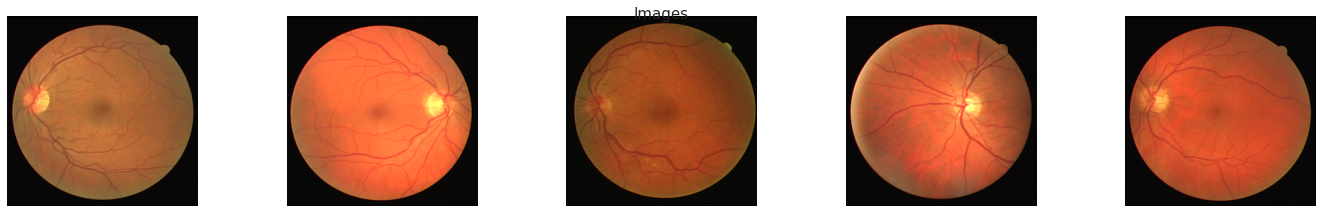

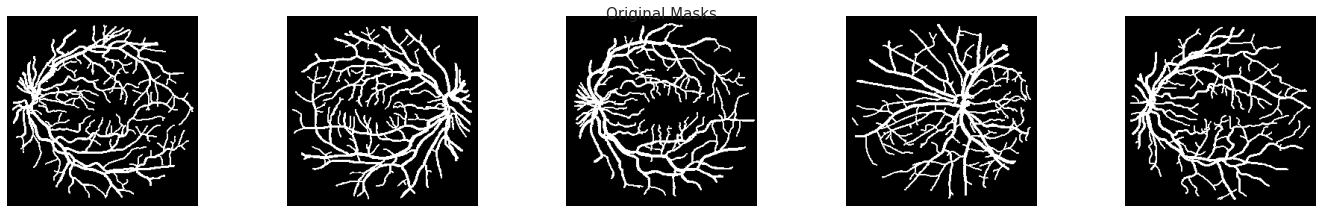

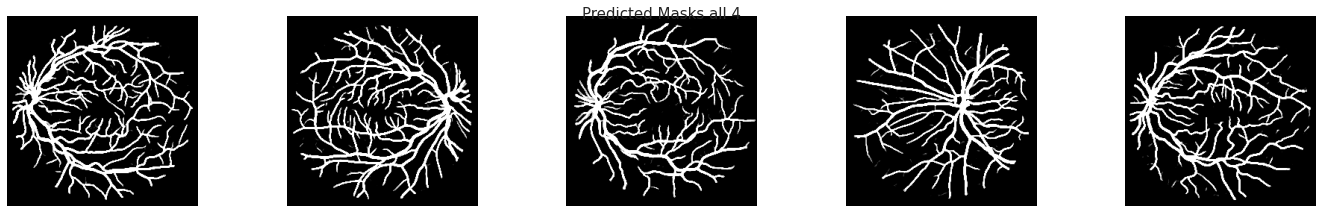

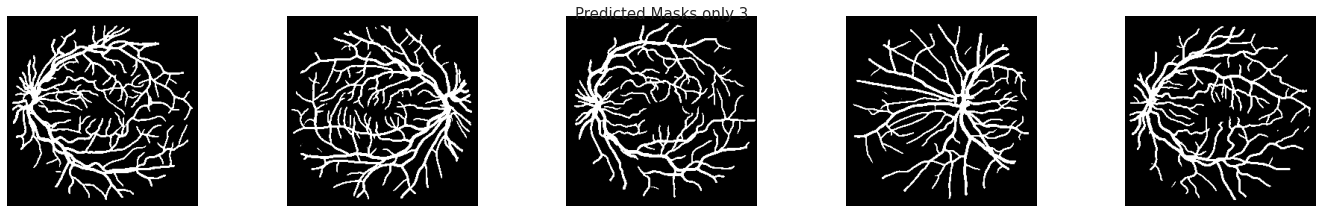

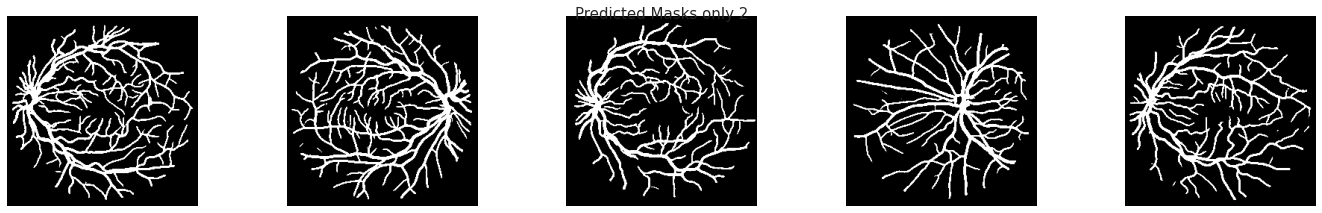

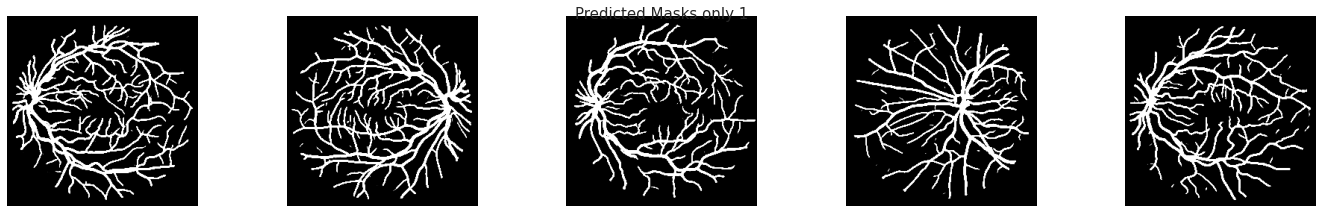

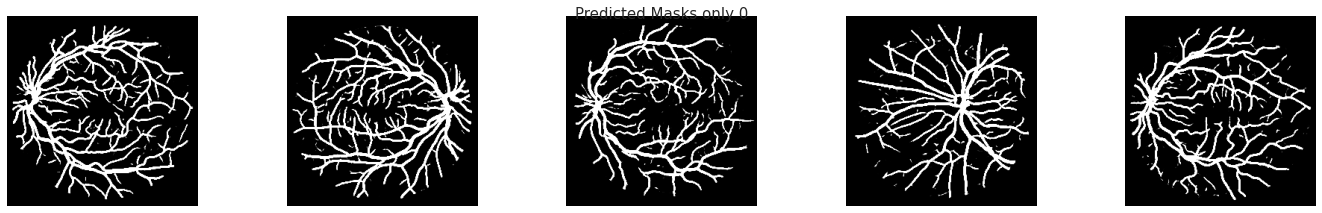

In [ ]:
figsize = (20, 3)

fig, axes = plt.subplots(1, 5, figsize=figsize)
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(x_val[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=figsize)
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(y_val[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

#.....................................................................

fig, axes = plt.subplots(1, 5, figsize=figsize)
fig.suptitle('Predicted Masks all 4', fontsize=15)
axes = axes.flatten()
for img, ax in zip(p_val1[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=figsize)
fig.suptitle('Predicted Masks only 3', fontsize=15)
axes = axes.flatten()
for img, ax in zip(p_val2[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=figsize)
fig.suptitle('Predicted Masks only 2', fontsize=15)
axes = axes.flatten()
for img, ax in zip(p_val3[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=figsize)
fig.suptitle('Predicted Masks only 1', fontsize=15)
axes = axes.flatten()
for img, ax in zip(p_val4[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=figsize)
fig.suptitle('Predicted Masks only 0', fontsize=15)
axes = axes.flatten()
for img, ax in zip(p_val5[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()